## Used to create plots & perform analysis of output produced by model based on dose variations
- Output data will be saved as files and then imported here to analyse/plot.

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

mystyle = r'https://gist.githubusercontent.com/mbolt01/3087dffd11e70eccb08fdcf327374a5c/raw/std_fig'
plt.style.use(mystyle)

## can do my modelling in this notebook too.
import TCP_NTCP as model

In [2]:
## functions to simply save and load files for use aftger producing modelling results

def save_pkl(obj,filename):
    pickle.dump(obj,open(filename,'wb'))

def load_pkl(filename):
    return pickle.load(open(filename,'rb'))

## example save:
#save_pkl(prost_10year,'test3.pkl')
## example load:
#newtest = load_pkl('test3.pkl')


## define colours to use for each type
color_p = 'C0'
color_hn_conf = 'C1'
color_hn_imrt = 'C2'

# Variation in doses
- Convolution of the different sources of dose variation.
    - Variation assumed to be normally distributed with standard deviations of:
        - Beam calibration: % (SD from NPL data) 
        - Output offset: % (variaiton in mean dose observed over a 2 month period for all meachines)
        - Daily variations: % (mean SD based on each machines farmer data)
- Convolution of normal distributions means just adding together the variances = SD^2
    - Total SD = sqrt(SD1^2 + SD2^2 + ...SDn^2)
    - https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables
    - http://mathworld.wolfram.com/NormalSumDistribution.html

In [3]:
## NPL MV data
## From the NPL Data the SD of the MV beam outputs is 0.7% (section 3.2.1)

## Systematic beam output
## From the first 7 weeks of output data this gives 0.7% also (section 4.3.7.2)

## Daily output fluctuations
## From the farmer chamber 0.2% (section 4.3.8)

npl_err = 0.7
op_err = 0.7
rand_err = 0.2

## convolute the erros together to give combined SDs
print('NPL only SD: ',npl_err)
npl_conv_op = np.sqrt(npl_err**2 + op_err**2)
print('NPL + Output SD: ',npl_conv_op)
npl_conv_op_conv_rand = np.sqrt(npl_err**2 + op_err**2 + rand_err**2)
print('NPL + Output + random SD: ',npl_conv_op_conv_rand)

print('--')
## produce 95% CI
print('NPL only 95%CI: ',npl_err*1.96)
print('NPL + Output 95%CI: ',npl_conv_op*1.96)
print('NPL + Output + random 95%CI: ',npl_conv_op_conv_rand*1.96)

## values to use:
print('--')
print('NPL only 95%CI use: ',1.4)
print('NPL + Output 95%CI use: ',1.9)
print('NPL + Output + random 95%CI use: ',2)

NPL only SD:  0.7
NPL + Output SD:  0.989949493661
NPL + Output + random SD:  1.00995049384
--
NPL only 95%CI:  1.3719999999999999
NPL + Output 95%CI:  1.94030100758
NPL + Output + random 95%CI:  1.97950296792
--
NPL only 95%CI use:  1.4
NPL + Output 95%CI use:  1.9
NPL + Output + random 95%CI use:  2


In [4]:
model.doses_array(n=1,n_frac = 50, d = 2, d_shift=0,d_sd=0,d_trend=0)

array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.]])

In [11]:
## function to get nominal doses and 

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***


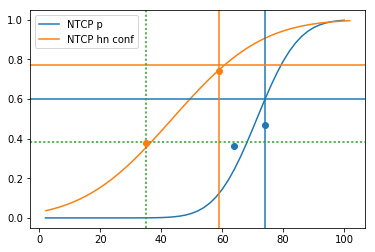

p TCP: 0.597382175553
hn conf TCP: 0.769709984014
hn imrt TCP: 0.38467165398


In [12]:
## use this to get dose array...

## this TCP part is only used to get a list of fraction doses and nominal doses
## this is easiest as the dose variaiotn is builtin.
TCP_results_p = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=2,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 74) ##*********

TCP_results_hn = model.completeTCPcalc(n=1,
                                      alphabeta_use=10,
                                      alphabeta_sd_use=0,
                                      d=65/30,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=59,
                                      n0 = 3000000) ##*********


frac_doses_p = TCP_results_p['doses']
nom_doses_p = TCP_results_p['nom_doses']
frac_doses_hn = TCP_results_hn['doses']
nom_doses_hn = TCP_results_hn['nom_doses']

## v is manually determined based ont he TCP/dose points

NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)

NTCP_results_hn = model.complete_NTCP_calc(d_data=[35,59],
                                       ntcp_data=[0.38,0.74],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0) ## this was fitted based on the data points
                                       fit_vals=False)

plt.plot(nom_doses_p,NTCP_results_p['patient_ntcps'][0],label='NTCP p')
plt.plot(nom_doses_hn,NTCP_results_hn['patient_ntcps'][0],label='NTCP hn conf')
## show dose of interest point
plt.axvline(74,c=color_p)
plt.axhline(NTCP_results_p['patient_ntcps'][0][36],c=color_p)
plt.axvline(59,c=color_hn_conf)
plt.axhline(NTCP_results_hn['patient_ntcps'][0][27],c=color_hn_conf)
plt.axvline(35,c=color_hn_imrt,ls=':')
plt.axhline(NTCP_results_hn['patient_ntcps'][0][16],c=color_hn_imrt,ls=':')

## show dose points
plt.plot(NTCP_results_p['d_data'],NTCP_results_p['ntcp_data'],'o',c=color_p)
plt.plot(NTCP_results_hn['d_data'],NTCP_results_hn['ntcp_data'],'o',c=color_hn_conf)


plt.legend()
plt.show()

## get TCP at doses of interest.

print('p TCP:',NTCP_results_p['patient_ntcps'][0][36])
print('hn conf TCP:',NTCP_results_hn['patient_ntcps'][0][27])
print('hn imrt TCP:',NTCP_results_hn['patient_ntcps'][0][16])

In [13]:
## have three doses of interest on these curves:
## HN_imrt = 35Gy [pos 16](mean IMRT dose to parotids)
## HN_conf = 59Gy [pos27](mean conformal dose to parotids) [gradient of NTCP for IMRT and conf doses is actually quite similar.]
## Prostate = 74Gy [pos36]

In [14]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ** this is the format required for analysis the dose variaiton.

## ************ d_dif **********

d_dif_res = {}

for d_dif in [0,1]: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=d_dif,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=d_dif, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    d_dif_res[d_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(d_dif_res):
    print(i,d_dif_res[i])
    
cases_d = {}

for case in d_dif_res[0]: ## loop each clinical case
    #print(case)
    orig = d_dif_res[0][case] ## 0% change
    new = d_dif_res[1][case] ## 1% change
    perc_dif = ((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_d[case] = perc_dif

print('')
    
print('% dif cased by 1% increase in change of dose')
print(cases_d)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
1 {'hn imrt': 0.39077549338584966, 'hn conf': 0.77760777117152124, 'prost': 0.62388844725191528}
hn imrt 0.385 0.391 1.587
hn conf 0.77 0.778 1.026
prost 0.597 0.624 4.437

% dif cased by 1% increase in change of dose
{'hn imrt': 1.5867661011995216, 'hn conf': 1.0260731082194718, 'prost': 4.4370710716840955}


In [15]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ************ m **********

m_dif_res = {}

for m_dif in [1,1.01]: ## vary the dose by this factor (0 and 1%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15*m_dif,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53*m_dif,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    m_dif_res[m_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(m_dif_res):
    print(i,m_dif_res[i])
    
cases_m = {}

for case in m_dif_res[1]: ## loop each clinical case
    #print(case)
    orig = m_dif_res[1][case] ## 0% change
    new = m_dif_res[1.01][case] ## 1% change
    perc_dif = ((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_m[case] = perc_dif

print('')
    
print('% dif cased by 1% increase in change of m')
print(cases_m)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
1.01 {'hn imrt': 0.38578163513947167, 'hn conf': 0.76748403367754781, 'prost': 0.59643709492771835}
hn imrt 0.385 0.386 0.289
hn conf 0.77 0.767 -0.289
prost 0.597 0.596 -0.158

% dif cased by 1% increase in change of m
{'hn imrt': 0.28855288618494512, 'hn conf': -0.2891933823066295, 'prost': -0.15820368668688634}


In [16]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ************ n **********

n_dif_res = {}

for n_dif in [1,0.99]: ## vary the dose by this factor (0 and 1%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13*n_dif,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1.0*n_dif,0)}, #(1,0)
                                           fit_vals=False)
    
    n_dif_res[n_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(n_dif_res):
    print(i,n_dif_res[i])
    
cases_n = {}

for case in n_dif_res[1]: ## loop each clinical case
    #print(case)
    orig = n_dif_res[1][case] ## 0% change
    new = n_dif_res[0.99][case] ## 1% change
    perc_dif = -((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_n[case] = perc_dif

print('')
    
print('% dif cased by 1% *decrease* in change of n - swapped sign...')
#print('note n is held fixed for H&N at 1, hence the decrease used as n is limited between 0-1')
print(cases_n)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0.99 {'hn imrt': 0.38667701525324244, 'hn conf': 0.77232587495696725, 'prost': 0.59847658808456272}
1 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
hn imrt 0.385 0.387 -0.521
hn conf 0.77 0.772 -0.34
prost 0.597 0.598 -0.183

% dif cased by 1% *decrease* in change of n - swapped sign...
{'hn imrt': -0.52131766219787323, 'hn conf': -0.33985410050862974, 'prost': -0.18320140377403593}


In [17]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ************ v **********

v_dif_res = {}

for v_dif in [1,1.01]: ## vary the dose by this factor (0 and 1%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73*v_dif,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72*v_dif,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    v_dif_res[v_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(v_dif_res):
    print(i,v_dif_res[i])
    
cases_v = {}

for case in v_dif_res[1]: ## loop each clinical case
    #print(case)
    orig = v_dif_res[1][case] ## 0% change
    new = v_dif_res[1.01][case] ## 1% change
    perc_dif = ((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_v[case] = perc_dif

print('')
    
print('% dif cased by 1% increase in change of v')
print(cases_v)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
1.01 {'hn imrt': 0.39077549338584994, 'hn conf': 0.77760777117152113, 'prost': 0.60084130086589427}
hn imrt 0.385 0.391 1.587
hn conf 0.77 0.778 1.026
prost 0.597 0.601 0.579

% dif cased by 1% increase in change of v
{'hn imrt': 1.5867661011995882, 'hn conf': 1.0260731082194496, 'prost': 0.579047292403434}


In [18]:
all_sens = {'d':cases_d,
           'v':cases_v,
           'm':cases_m,
           'n':cases_n}
all_sens

{'d': {'hn conf': 1.0260731082194718,
  'hn imrt': 1.5867661011995216,
  'prost': 4.4370710716840955},
 'm': {'hn conf': -0.2891933823066295,
  'hn imrt': 0.28855288618494512,
  'prost': -0.15820368668688634},
 'n': {'hn conf': -0.33985410050862974,
  'hn imrt': -0.52131766219787323,
  'prost': -0.18320140377403593},
 'v': {'hn conf': 1.0260731082194496,
  'hn imrt': 1.5867661011995882,
  'prost': 0.579047292403434}}

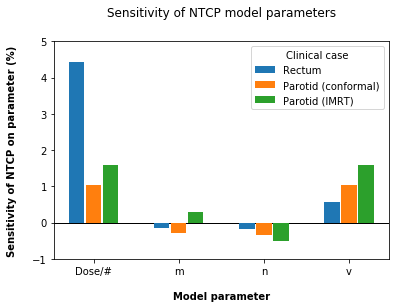

In [19]:
## create barplot of results
the_params = ['d','m','n','v']
the_tick_labels = ['Dose/#','m','n','v']

p_vals = [all_sens[i]['prost'] for i in the_params] ## rectum vals
hn_conf_vals = [all_sens[i]['hn conf'] for i in the_params] ## parotid conformal
hn_imrt_vals = [all_sens[i]['hn imrt'] for i in the_params] ## parotid imrt

offset = 0.2
width = 0.18
plt.bar(left=[0-offset,1-offset,2-offset,3-offset],height=p_vals,width=width,label='Rectum')
plt.bar(left=[0,1,2,3],height=hn_conf_vals,width=width,label='Parotid (conformal)')
plt.bar(left=[0+offset,1+offset,2+offset,3+offset],height=hn_imrt_vals,width=width,label='Parotid (IMRT)')
plt.axhline(0,c='black',lw=1,zorder=0)
plt.ylabel('Sensitivity of NTCP on parameter (%)')
plt.xlabel('Model parameter')
plt.xticks([0,1,2,3],the_tick_labels)
plt.ylim(-1,5)
plt.title('Sensitivity of NTCP model parameters')

plt.legend(title='Clinical case')
#plt.savefig('NTCP_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()
## this plot is reversed to what I want.. TNeed to swap x axis and legend around... 

# Different variations in dose.
- Systematic  + Random
- Quantified to match the TCP analysis

## known systematic dose difference
- Known beam output - model single 'typical' patient with different beam outputs.
- Collate the NTCP for each case and plot NTCP dif (%) vs dose dif (%)

In [20]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ** this is the format required for analysis the dose variaiton.

## ************ d_dif **********

## store each set of results.
p_res = {}
hn_conf_res = {}
hn_imrt_res = {}

#d_difs = [-2,-1,0,1,2,3]
d_difs = np.arange(-5,5,0.25)

for d_dif in d_difs: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=d_dif,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=d_dif, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    p_res[d_dif] = NTCP_results_p['patient_ntcps'][0][36]
    hn_conf_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][27]
    hn_imrt_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][16]## get the result at the required dose points


Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***

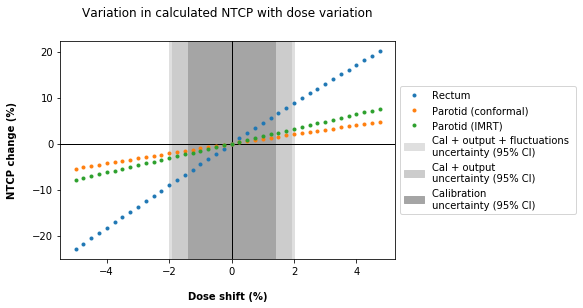

shift -5.0 rectum -22.91 parotid conf -5.42 parotid imrt -7.82
shift -4.75 rectum -21.76 parotid conf -5.14 parotid imrt -7.43
shift -4.5 rectum -20.61 parotid conf -4.86 parotid imrt -7.04
shift -4.25 rectum -19.45 parotid conf -4.58 parotid imrt -6.66
shift -4.0 rectum -18.3 parotid conf -4.3 parotid imrt -6.27
shift -3.75 rectum -17.15 parotid conf -4.02 parotid imrt -5.88
shift -3.5 rectum -15.99 parotid conf -3.75 parotid imrt -5.49
shift -3.25 rectum -14.84 parotid conf -3.47 parotid imrt -5.1
shift -3.0 rectum -13.69 parotid conf -3.2 parotid imrt -4.71
shift -2.75 rectum -12.53 parotid conf -2.92 parotid imrt -4.32
shift -2.5 rectum -11.38 parotid conf -2.65 parotid imrt -3.93
shift -2.25 rectum -10.23 parotid conf -2.38 parotid imrt -3.54
shift -2.0 rectum -9.08 parotid conf -2.11 parotid imrt -3.15
shift -1.75 rectum -7.94 parotid conf -1.84 parotid imrt -2.76
shift -1.5 rectum -6.79 parotid conf -1.58 parotid imrt -2.37
shift -1.25 rectum -5.65 parotid conf -1.31 parotid imr

In [21]:

## get percentage difference results
p_perc = []
hn_conf_perc = []
hn_imrt_perc = []

for d in d_difs:
    p_orig = p_res[0]
    p_d = p_res[d]
    p_dif = ((p_d/p_orig)-1)*100
    p_perc.append(p_dif)
    
    hn_conf_orig = hn_conf_res[0]
    hn_conf_d = hn_conf_res[d]
    hn_conf_dif = ((hn_conf_d/hn_conf_orig)-1)*100
    hn_conf_perc.append(hn_conf_dif)
    
    hn_imrt_orig = hn_imrt_res[0]
    hn_imrt_d = hn_imrt_res[d]
    hn_imrt_dif = ((hn_imrt_d/hn_imrt_orig)-1)*100
    hn_imrt_perc.append(hn_imrt_dif)
    
plt.plot(d_difs,p_perc,'o',c=color_p,label='Rectum',ms=3)
plt.plot(d_difs,hn_conf_perc,'o',c=color_hn_conf,label='Parotid (conformal)',ms=3)
plt.plot(d_difs,hn_imrt_perc,'o',c=color_hn_imrt,label='Parotid (IMRT)',ms=3)

plt.axhline(0,color='black',lw=1,zorder=0)
plt.axvline(0,color='black',lw=1,zorder=0)

plt.xlabel('Dose shift (%)')
plt.ylabel('NTCP change (%)')
plt.title('Variation in calculated NTCP with dose variation')


## shade the regions of interest with different colours and labels
output_errors = {1.4:{'label':'Calibration \nuncertainty (95% CI)',
                    'color':'#a5a5a5'},
                 1.9:{'label':'Cal + output \nuncertainty (95% CI)',
                   'color':'#cccccc'},
                2:{'label':'Cal + output + fluctuations \nuncertainty (95% CI)',
                   'color':'#dfdfdf'}}

for val in sorted(output_errors,reverse=True):
    plt.axvspan(-val,val,alpha=1,color=output_errors[val]['color'],zorder=0,label=output_errors[val]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('NTCP-systematic_dose_dif.png',dpi=300,bbox_inches='tight')

plt.show()
## show the numerical results
for i in range(len(d_difs)):
    print('shift',d_difs[i],'rectum',round(p_perc[i],2),'parotid conf',round(hn_conf_perc[i],2),'parotid imrt',round(hn_imrt_perc[i],2))

## Variation due to machine scheduling.
- Create plot of NTCPs with 95% CI shaded.
- 100 patients on machines with dose with SD of 1.0% = combined machine and beam cal SD.

In [62]:
## this takes a while...

## generate 1000 random dose deviaitons from normal distribution
the_n = 1000 ##1000 used for final thing
the_sd = 0.4
the_mean = 0
dose_shifts = np.random.normal(loc=the_mean,scale=the_sd,size=the_n)

## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ** this is the format required for analysis the dose variaiton.

## ************ d_dif **********

## store each set of results.
p_res = {}
hn_conf_res = {}
hn_imrt_res = {}

ntcp_p_res = []
ntcp_hn_res = []
i=0

for d_dif in dose_shifts: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=d_dif,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=d_dif, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    #print(frac_doses_p)
    #print(NTCP_results_p['patient_ntcps'][0])
    p_res[d_dif] = NTCP_results_p['patient_ntcps'][0][36]
    hn_conf_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][27]
    hn_imrt_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][16]## get the result at the required dose points
    
    ntcp_p_res.append(NTCP_results_p['patient_ntcps'][0])
    ntcp_hn_res.append(NTCP_results_hn['patient_ntcps'][0])
    i=i+1
    print(i)
    
#plt.show()

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
2
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
3
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
4
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
5
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
6
Calculating Individual Patient NTCP curves
*** NTCP Simulation C

In [63]:
all_data = {'p':ntcp_p_res,
           'hn':ntcp_hn_res}
save_pkl(all_data,'ntcp_machine_assign_04perc.pkl')

ntcp_mach_1perc = load_pkl('ntcp_machine_assign_1perc.pkl')
ntcp_mach_08perc = load_pkl('ntcp_machine_assign_08perc.pkl')
ntcp_mach_04perc = load_pkl('ntcp_machine_assign_04perc.pkl')

## these data items contain NTCP results for 1000 patients.
## 1perc is for NPL + OP
## 08perc is for NPL only.
## 04perc is NPL most recent value
## can use these to get boxplots of NTPC var at specific points.

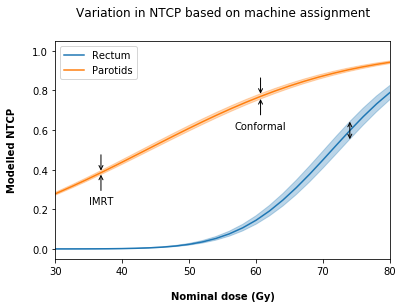

In [104]:
## create a plot with prost and HN data. Add arrows at the doses of interest.

ntcp_p_mean = np.mean(ntcp_mach_1perc['p'],axis=0)
ntcp_p_5perc = np.percentile(ntcp_mach_1perc['p'],5,axis=0)
ntcp_p_95perc = np.percentile(ntcp_mach_1perc['p'],95,axis=0)

plt.plot(nom_doses_p,ntcp_p_mean,label='Rectum')
plt.fill_between(nom_doses_p,ntcp_p_5perc,ntcp_p_95perc,
                color=color_p,zorder=0,alpha=0.3)

ntcp_hn_mean = np.mean(ntcp_mach_1perc['hn'],axis=0)
ntcp_hn_5perc = np.percentile(ntcp_mach_1perc['hn'],5,axis=0)
ntcp_hn_95perc = np.percentile(ntcp_mach_1perc['hn'],95,axis=0)

plt.plot(nom_doses_hn,ntcp_hn_mean,label='Parotids')
plt.fill_between(nom_doses_hn,ntcp_hn_5perc,ntcp_hn_95perc,
                color=color_hn_conf,zorder=0,alpha=0.3)

plt.xlim(30,80)
plt.legend()

## show range of interest with arrows
## use annotate with no text as it seems easier
### rectum
plt.annotate(s='', xy=(74,ntcp_p_5perc[36]), xytext=(74,ntcp_p_95perc[36]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

## parotid_conformal (dose is rounded to nearest fraction - posn 27 = #28)
plt.annotate(s='', xy=(28*65/30,ntcp_hn_5perc[27]-0.08), xytext=(28*65/30,ntcp_hn_5perc[27]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))
plt.annotate(s='', xy=(28*65/30,ntcp_hn_95perc[27]+0.08), xytext=(28*65/30,ntcp_hn_95perc[27]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

## parotid_IMRT (dose is rounded to nearest fraction - posn 16 = #17)
plt.annotate(s='', xy=(17*65/30,ntcp_hn_5perc[16]-0.08), xytext=(17*65/30,ntcp_hn_5perc[16]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))
plt.annotate(s='', xy=(17*65/30,ntcp_hn_95perc[16]+0.08), xytext=(17*65/30,ntcp_hn_95perc[16]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

plt.text(17*65/30,ntcp_hn_5perc[16]-0.15,'IMRT',horizontalalignment='center')
plt.text(28*65/30,ntcp_hn_5perc[27]-0.15,'Conformal',horizontalalignment='center')

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('Modelled NTCP')
plt.title('Variation in NTCP based on machine assignment')

#plt.savefig('ntcp_95CI-p+hn.png',dpi=300,bbox_inches='tight')

plt.show()

In [66]:
## Now want to take the above results, 
## get the NTCP at the dose of interest and plot these as boxplots.

ntcp_p_d_int_npl_04 = []
ntcp_hn_conf_d_int_npl_04 = []
ntcp_hn_imrt_d_int_npl_04 = []

ntcp_p_d_int_npl = []
ntcp_hn_conf_d_int_npl = []
ntcp_hn_imrt_d_int_npl = []

ntcp_p_d_int_npl_op = []
ntcp_hn_conf_d_int_npl_op = []
ntcp_hn_imrt_d_int_npl_op = []

## get rectum stuff
for i in range(len(ntcp_mach_04perc['p'])):
    ntcp_p_d_int_npl_04.append(((ntcp_mach_04perc['p'][i][36]/np.mean(ntcp_mach_04perc['p'],axis=0)[36])-1)*100)

for i in range(len(ntcp_mach_08perc['p'])):
    ntcp_p_d_int_npl.append(((ntcp_mach_08perc['p'][i][36]/np.mean(ntcp_mach_08perc['p'],axis=0)[36])-1)*100)

for i in range(len(ntcp_mach_1perc['p'])):
    ntcp_p_d_int_npl_op.append(((ntcp_mach_1perc['p'][i][36]/np.mean(ntcp_mach_1perc['p'],axis=0)[36])-1)*100)

## get hn conf stuff
for i in range(len(ntcp_mach_04perc['hn'])):
    ntcp_hn_conf_d_int_npl_04.append(((ntcp_mach_04perc['hn'][i][27]/np.mean(ntcp_mach_04perc['hn'],axis=0)[27])-1)*100)

for i in range(len(ntcp_mach_08perc['hn'])):
    ntcp_hn_conf_d_int_npl.append(((ntcp_mach_08perc['hn'][i][27]/np.mean(ntcp_mach_08perc['hn'],axis=0)[27])-1)*100)

for i in range(len(ntcp_mach_1perc['hn'])):
    ntcp_hn_conf_d_int_npl_op.append(((ntcp_mach_1perc['hn'][i][27]/np.mean(ntcp_mach_1perc['hn'],axis=0)[27])-1)*100)

## get hn imrt stuff
for i in range(len(ntcp_mach_04perc['hn'])):
    ntcp_hn_imrt_d_int_npl_04.append(((ntcp_mach_04perc['hn'][i][16]/np.mean(ntcp_mach_04perc['hn'],axis=0)[16])-1)*100)

for i in range(len(ntcp_mach_08perc['hn'])):
    ntcp_hn_imrt_d_int_npl.append(((ntcp_mach_08perc['hn'][i][16]/np.mean(ntcp_mach_08perc['hn'],axis=0)[16])-1)*100)

for i in range(len(ntcp_mach_1perc['hn'])):
    ntcp_hn_imrt_d_int_npl_op.append(((ntcp_mach_1perc['hn'][i][16]/np.mean(ntcp_mach_1perc['hn'],axis=0)[16])-1)*100)


NPL 04 sds
1.72430988109
0.399148209123
0.610163100153
NPL sds
3.54341225834
0.820711693352
1.25442851755
NPL + OP sds
4.4346160286
1.02820162416
1.57254385028


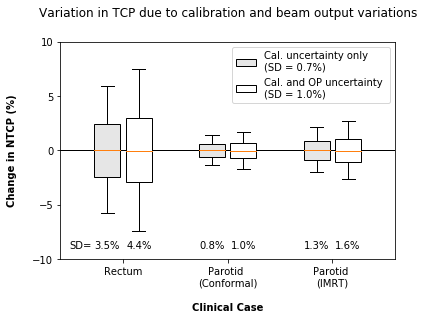

In [68]:
## plot it

ntcp_box_npl_04 = [ntcp_p_d_int_npl_04,ntcp_hn_conf_d_int_npl_04,ntcp_hn_imrt_d_int_npl_04]
ntcp_box_npl = [ntcp_p_d_int_npl,ntcp_hn_conf_d_int_npl,ntcp_hn_imrt_d_int_npl]
ntcp_box_npl_op = [ntcp_p_d_int_npl_op,ntcp_hn_conf_d_int_npl_op,ntcp_hn_imrt_d_int_npl_op]

print('NPL 04 sds')
for i in ntcp_box_npl_04:
    print(np.std(i))
print('NPL sds')
for i in ntcp_box_npl:
    print(np.std(i))
print('NPL + OP sds')
for i in ntcp_box_npl_op:
    print(np.std(i))

offset = 0.15
width = 0.25

fig, ax = plt.subplots()

bp1=plt.boxplot(ntcp_box_npl,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
           positions=[1-offset,2-offset,3-offset], patch_artist=True,boxprops={'facecolor':'#E6E6E6','alpha':1,'edgecolor':'black'})

bp2=plt.boxplot(ntcp_box_npl_op,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
           positions=[1+offset,2+offset,3+offset], patch_artist=True,boxprops={'facecolor':'white','alpha':1,'edgecolor':'black'})

plt.xticks([1,2,3],['Rectum','Parotid \n(Conformal)', 'Parotid \n(IMRT)'])

plt.title('Variation in TCP due to calibration and beam output variations')
plt.xlabel('Clinical Case')
plt.ylabel('Change in NTCP (%)')

plt.axhline(0,color='black',lw=1,zorder=0)

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Cal. uncertainty only \n(SD = 0.7%)', 'Cal. and OP uncertainty \n(SD = 1.0%)'])

text_x = [0.85,1.85,2.85,1.15,2.15,3.15] ## manually set

the_sds = []
for i in ntcp_box_npl:
    the_sds.append(np.std(i))
for i in ntcp_box_npl_op:
    the_sds.append(np.std(i))

for i in range(len(text_x)):
    plt.text(text_x[i],-9,str(round(the_sds[i],1))+'%',horizontalalignment='center')

plt.text(0.7,-9,'SD=',horizontalalignment='right')

plt.ylim(-10,10)
plt.xlim(0.4,3.6)

plt.yticks([-10,-5,0,5,10])

#plt.savefig('ntcp_npl_op_boxplot.png',dpi=300,bbox_inches='tight')

plt.show()

## Annual drift
- Range =-10 to +10 - get NTCP at each of the dose points
- shaded range = -3.5 to +5.3 = 95% CI of drifts (%/yr)

In [8]:
## ************ dose drift **********

## store each set of results.
p_res = {}
hn_conf_res = {}
hn_imrt_res = {}

d_drifts = np.linspace(-10,10,41) ## every 0.5%

for d_dif in d_drifts: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=d_dif/365, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=d_dif/365, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    p_res[d_dif] = NTCP_results_p['patient_ntcps'][0][36]
    hn_conf_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][27]
    hn_imrt_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][16]## get the result at the required dose points






Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***

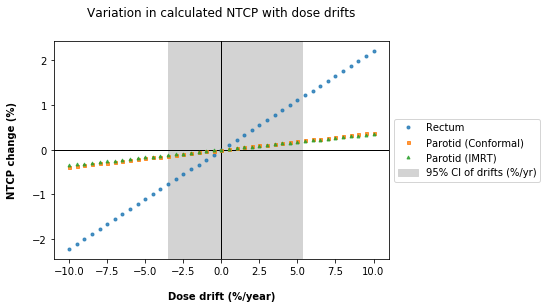

In [16]:
## calcualte % change in NTCPs

drift_perc = []
drift_p_perc = []
drift_hn_conf_perc = []
drift_hn_imrt_perc = []

for i in sorted(p_res.keys()):
    
    drift_perc.append(i)
    drift_p_perc.append(((p_res[i]/p_res[0])-1)*100)
    drift_hn_conf_perc.append(((hn_conf_res[i]/hn_conf_res[0])-1)*100)
    drift_hn_imrt_perc.append(((hn_imrt_res[i]/hn_imrt_res[0])-1)*100)
    
## plot results
plt.plot(drift_perc,drift_p_perc,'o',ms=3,color=color_p,label='Rectum',alpha=0.8)
plt.plot(drift_perc,drift_hn_conf_perc,'s',ms=3,color=color_hn_conf,label='Parotid (Conformal)',alpha=0.8)
plt.plot(drift_perc,drift_hn_imrt_perc,'^',ms=3,color=color_hn_imrt,label='Parotid (IMRT)',alpha=0.8)

plt.axvline(0,color='black',lw=1,zorder=0)
plt.axhline(0,color='black',lw=1,zorder=0)
## shade the regions of interest with different colours and labels
plt.axvspan(-3.5,5.3,alpha=1,color='lightgrey',zorder=0,label='95% CI of drifts (%/yr)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Dose drift (%/year)')
plt.ylabel('NTCP change (%)')
plt.title('Variation in calculated NTCP with dose drifts')

#plt.savefig('NTCP-dose_drift_var.png',dpi=300,bbox_inches='tight')

plt.show()

## Impact of (daily) dose SD on NTCP SD
- Range of dose SDs from 0 - 2% (every 0.1%)
- Measure SD of NTCP at the dose points for each case.
- Can use built-in multi patient fucitons of models.
    - Use n=1000

In [46]:
d_sds = np.linspace(start = 0,stop = 2,num = 21,endpoint=True)
#d_sds = [0,1,2]
p_sd_res = {}
hn_conf_sd_res = {}
hn_imrt_sd_res = {}


for d_dif in d_sds: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1000,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=d_dif,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1000,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=d_dif,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    p_sd_res[d_dif] = NTCP_results_p['patient_ntcps'] ## save entire NTCP curves
    hn_conf_sd_res[d_dif] = NTCP_results_hn['patient_ntcps']
    hn_imrt_sd_res[d_dif] = NTCP_results_hn['patient_ntcps']

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***

In [48]:
#save_pkl(p_sd_res,'NTCP_p_res_dailySD.pkl')
#save_pkl(hn_conf_sd_res,'NTCP_hn_conf_res_dailySD.pkl')
#save_pkl(hn_imrt_sd_res,'NTCP_hn_imrt_res_dailySD.pkl')

p_res = load_pkl('NTCP_p_res_dailySD.pkl')
hn_conf_res = load_pkl('NTCP_hn_conf_res_dailySD.pkl')
hn_imrt_res = load_pkl('NTCP_hn_imrt_res_dailySD.pkl')

0.0 0.0 0.0 0.0
0.1 0.07 0.02 0.04
0.2 0.15 0.04 0.08
0.3 0.22 0.06 0.12
0.4 0.3 0.08 0.16
0.5 0.37 0.1 0.19
0.6 0.45 0.11 0.22
0.7 0.52 0.14 0.28
0.8 0.58 0.15 0.3
0.9 0.67 0.18 0.34
1.0 0.72 0.2 0.39
1.1 0.83 0.21 0.4
1.2 0.88 0.24 0.48
1.3 0.93 0.25 0.49
1.4 0.97 0.27 0.52
1.5 1.06 0.3 0.58
1.6 1.2 0.31 0.61
1.7 1.32 0.33 0.62
1.8 1.31 0.35 0.69
1.9 1.42 0.37 0.72
2.0 1.54 0.41 0.79


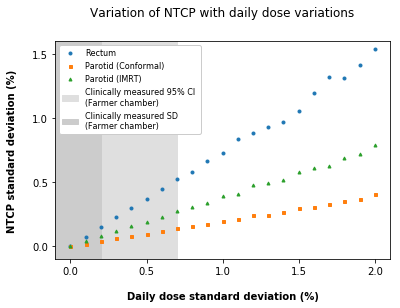

In [61]:
## get the NTCP values at each required dose point and get SD

dose_sds = []
p_sd_percs = []
hn_conf_sd_percs = []
hn_imrt_sd_percs = []
for i in sorted(p_res.keys()):
    dose_sds.append(i)
    p_sd_percs.append(100*np.std(p_res[i],axis=0)[36]/np.mean(p_res[i],axis=0)[36])
    hn_conf_sd_percs.append(100*np.std(hn_conf_res[i],axis=0)[27]/np.mean(hn_conf_res[i],axis=0)[27])
    hn_imrt_sd_percs.append(100*np.std(hn_imrt_res[i],axis=0)[16]/np.mean(hn_imrt_res[i],axis=0)[16])
    print(i,
         round(100*np.std(p_res[i],axis=0)[36]/np.mean(p_res[i],axis=0)[36],2),
         round(100*np.std(hn_conf_res[i],axis=0)[27]/np.mean(hn_conf_res[i],axis=0)[27],2),
         round(100*np.std(hn_imrt_res[i],axis=0)[16]/np.mean(hn_imrt_res[i],axis=0)[16],2))

    
## create plot

plt.plot(dose_sds,p_sd_percs,'o',color=color_p,ms=3,label='Rectum')
plt.plot(dose_sds,hn_conf_sd_percs,'s',color=color_hn_conf,ms=3,label='Parotid (Conformal)')
plt.plot(dose_sds,hn_imrt_sd_percs,'^',color=color_hn_imrt,ms=3,label='Parotid (IMRT)')


plt.axvspan(-1,0.7,alpha=1,color='#dfdfdf',zorder=0,label='Clinically measured 95% CI \n(Farmer chamber)')
plt.axvspan(-1,0.2,alpha=1,color='#cccccc',zorder=0,label='Clinically measured SD \n(Farmer chamber)')


leg = plt.legend(loc='upper left',fontsize=8)
leg.get_frame().set_alpha(1)

plt.xlim(-0.1,2.1)
plt.xticks([0,0.5,1,1.5,2])
plt.ylim(-0.1,1.6)
plt.yticks([0,0.5,1,1.5])


plt.title('Variation of NTCP with daily dose variations')
plt.ylabel('NTCP standard deviation (%)')
plt.xlabel('Daily dose standard deviation (%)')

#plt.savefig('NTCP_daily_dose_SD.png',dpi=300,bbox_inches='tight')
plt.show()

In [41]:
## SD at required dose in %
p_sd_perc = np.std(p_res[1],axis=0)[36]
## mean at required dose so can calc SD at percent
np.mean(p_res[1],axis=0)[36]

0.59679346635765373

## Change from 0.8% to 0.4% SD in beam calibration
- Get the NTCP variation (SD) for eahc case with a set of beam with 0.8% and 0.4% SD.
- This is done usign the 'machine scheduling' method.
    - A new set of 0.4% deviation was created.